# Backup


In [ ]:
# DONT RUN AGAIN
def count_images_in_folder(base_path):
    results = {}
    for split in splits:
        split_path = os.path.join(base_path, split)
        expression_counts = {}
        if not os.path.exists(split_path):
            print(f"{split_path} does not exist.")
            continue
        for expression in sorted(os.listdir(split_path)):
            expression_path = os.path.join(split_path, expression)
            if os.path.isdir(expression_path):
                image_count = len([
                    f for f in os.listdir(expression_path)
                    if os.path.isfile(os.path.join(expression_path, f))
                    and f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                expression_counts[expression] = image_count
        results[split] = expression_counts
    return results

# Set the dataset directory
dataset_path = "/content/drive/MyDrive/facial expression classification"
# Count images
image_counts = count_images_in_folder(dataset_path)
# Print results
for split in splits:
    print(f"\n--- {split.upper()} SET ---")
    expressions = image_counts.get(split, {})
    for expression, count in expressions.items():
        print(f"{expression}: {count}")


--- TRAIN SET ---
angry: 3693
disgust: 336
fear: 3803
happy: 6864
neutral: 4682
sad: 4638
surprise: 2905

--- TEST SET ---
angry: 300
disgust: 100
fear: 300
happy: 300
neutral: 300
sad: 300
surprise: 300

--- VALIDATION SET ---
angry: 960
disgust: 111
fear: 1018
happy: 1825
neutral: 1216
sad: 1139
surprise: 797


In [ ]:
# Function to remove a class folder
def remove_class_folders(base_dir, splits, class_name):
    for split in splits:
        class_path = os.path.join(base_dir, split, class_name)
        if os.path.exists(class_path):
            print(f"Removing folder: {class_path}")
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                os.remove(file_path)
            os.rmdir(class_path)
        else:
            print(f"Folder not found: {class_path}")

# Function to reduce all classes in the train set to target_count images
def reduce_all_classes_to_target(base_dir, split, target):
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            images = [
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]
            if len(images) > target:
                to_remove = len(images) - target
                images_to_remove = random.sample(images, to_remove)
                for img in images_to_remove:
                    os.remove(os.path.join(class_path, img))
                print(f"Reduced '{class_name}' from {len(images)} to {target} images.")
            else:
                print(f"'{class_name}' has {len(images)} images — no need to reduce.")

# Run operations
remove_class_folders(base_dir, splits, 'disgust')
reduce_all_classes_to_target(base_dir, 'train', 2000)

Removing folder: /content/drive/MyDrive/facial expression classification/train/disgust
Removing folder: /content/drive/MyDrive/facial expression classification/test/disgust
Removing folder: /content/drive/MyDrive/facial expression classification/validation/disgust
Reduced 'angry' from 3693 to 2000 images.
Reduced 'fear' from 3803 to 2000 images.
Reduced 'happy' from 6864 to 2000 images.
Reduced 'neutral' from 4682 to 2000 images.
Reduced 'sad' from 4638 to 2000 images.
Reduced 'surprise' from 2905 to 2000 images.


In [ ]:
# DO NOT RUN
# Define your dataset directories
data_dirs = {
    'train': '/content/drive/MyDrive/facial expression classification/train',
    'val': '/content/drive/MyDrive/facial expression classification/validation',
    'test': '/content/drive/MyDrive/facial expression classification/test',
}
corrupted_files = []
# Check for corrupted images
for split, data_dir in data_dirs.items():
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()  # verify the image
                    except Exception as e:
                        print(f"Corrupted file detected and deleted: {img_path}")
                        corrupted_files.append(img_path)
                        os.remove(img_path)
if not corrupted_files:
    print("No corrupted files found.")
else:
    print(f"Total corrupted files removed: {len(corrupted_files)}")

Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/angry/15395.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/angry/8887.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/angry/18369.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/fear/20859.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/fear/16790.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/fear/28654.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/fear/20295.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classification/train/happy/3963.jpg
Corrupted file detected and deleted: /content/drive/MyDrive/facial expression classifi

#3.1 Part A: Implementing Convolutional Neural Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#3.1.1 Data Understanding, Analysis, Visualization and Cleaning

Imports and Initial Setup

In [2]:
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset base directory
base_dir = "/content/drive/MyDrive/Facial Expression"
splits = ['train', 'test', 'validation']
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Function to Count Images in Folders

In [6]:
def count_images_in_folder(base_path):
    results = {}
    for split in splits:
        split_path = os.path.join(base_path, split)
        expression_counts = {}
        if not os.path.exists(split_path):
            print(f"{split_path} does not exist.")
            continue
        for expression in sorted(os.listdir(split_path)):
            expression_path = os.path.join(split_path, expression)
            if os.path.isdir(expression_path):
                image_count = len([
                    f for f in os.listdir(expression_path)
                    if os.path.isfile(os.path.join(expression_path, f))
                    and f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                expression_counts[expression] = image_count
        results[split] = expression_counts
    return results

# Set the dataset directory
dataset_path = "/content/drive/MyDrive/Facial Expression"
# Count images
image_counts = count_images_in_folder(dataset_path)
# Print results
for split in splits:
    print(f"\n--- {split.upper()} SET ---")
    expressions = image_counts.get(split, {})
    for expression, count in expressions.items():
        print(f"{expression}: {count}")


--- TRAIN SET ---
angry: 2000
fear: 1999
happy: 1996
neutral: 1998
sad: 1998
surprise: 1996

--- TEST SET ---
angry: 300
fear: 188
happy: 300
neutral: 300
sad: 110
surprise: 300

--- VALIDATION SET ---
angry: 960
fear: 1018
happy: 1825
neutral: 1226
sad: 1139
surprise: 797


Remove the disgust Class and Reduce Other Classes

In [ ]:
# DO NOT RUN
# Function to remove a class folder
def remove_class_folders(base_dir, splits, class_name):
    for split in splits:
        class_path = os.path.join(base_dir, split, class_name)
        if os.path.exists(class_path):
            print(f"Removing folder: {class_path}")
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                os.remove(file_path)
            os.rmdir(class_path)
        else:
            print(f"Folder not found: {class_path}")

# Function to reduce all classes in the train set to target_count images
def reduce_all_classes_to_target(base_dir, split, target):
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            images = [
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]
            if len(images) > target:
                to_remove = len(images) - target
                images_to_remove = random.sample(images, to_remove)
                for img in images_to_remove:
                    os.remove(os.path.join(class_path, img))
                print(f"Reduced '{class_name}' from {len(images)} to {target} images.")
            else:
                print(f"'{class_name}' has {len(images)} images — no need to reduce.")

# Run operations
remove_class_folders(base_dir, splits, 'disgust')
reduce_all_classes_to_target(base_dir, 'train', 2000)

Removing folder: /content/drive/MyDrive/facial expression classification/train/disgust
Removing folder: /content/drive/MyDrive/facial expression classification/test/disgust
Removing folder: /content/drive/MyDrive/facial expression classification/validation/disgust
Reduced 'angry' from 3693 to 2000 images.
Reduced 'fear' from 3803 to 2000 images.
Reduced 'happy' from 6864 to 2000 images.
Reduced 'neutral' from 4682 to 2000 images.
Reduced 'sad' from 4638 to 2000 images.
Reduced 'surprise' from 2905 to 2000 images.


Count Images Again After Removal and Reduction

In [4]:
# Update classes list to exclude 'disgust'
classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Count images per class per split
def count_images_per_class(base_dir, splits, classes):
    class_counts = {split: {cls: 0 for cls in classes} for split in splits}
    for split in splits:
        for cls in classes:
            cls_path = os.path.join(base_dir, split, cls)
            if os.path.exists(cls_path):
                class_counts[split][cls] = len(os.listdir(cls_path))
    return class_counts

# Get class distribution
counts = count_images_per_class(base_dir, splits, classes)
# Print counts
for split in splits:
    print(f"\n--- {split.upper()} SET ---")
    for cls in classes:
        print(f"{cls}: {counts[split][cls]}")


--- TRAIN SET ---
angry: 2000
fear: 1999
happy: 1996
neutral: 1998
sad: 1998
surprise: 1996

--- TEST SET ---
angry: 300
fear: 188
happy: 300
neutral: 300
sad: 110
surprise: 300

--- VALIDATION SET ---
angry: 960
fear: 1018
happy: 1825
neutral: 1226
sad: 1139
surprise: 797


Check for Corrupted Files

In [7]:
# Define your dataset directories
data_dirs = {
    'train': '/content/drive/MyDrive/Facial Expression/train',
    'val': '/content/drive/MyDrive/Facial Expression/validation',
    'test': '/content/drive/MyDrive/Facial Expression/test',
}
corrupted_files = []
# Check for corrupted images
for split, data_dir in data_dirs.items():
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()  # verify the image
                    except Exception as e:
                        print(f"Corrupted file detected and deleted: {img_path}")
                        corrupted_files.append(img_path)
                        os.remove(img_path)
if not corrupted_files:
    print("No corrupted files found.")
else:
    print(f"Total corrupted files removed: {len(corrupted_files)}")

No corrupted files found.


Plot Bar Charts for Class Distribution

<ipython-input-8-076f46f99768>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")


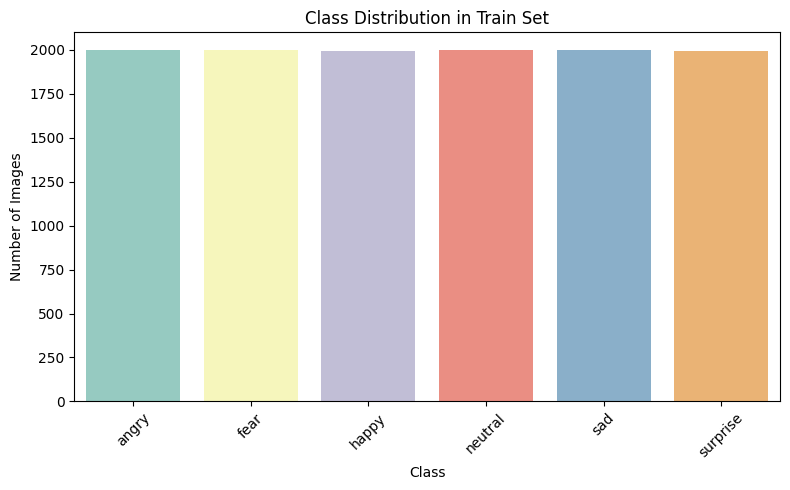

<ipython-input-8-076f46f99768>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")


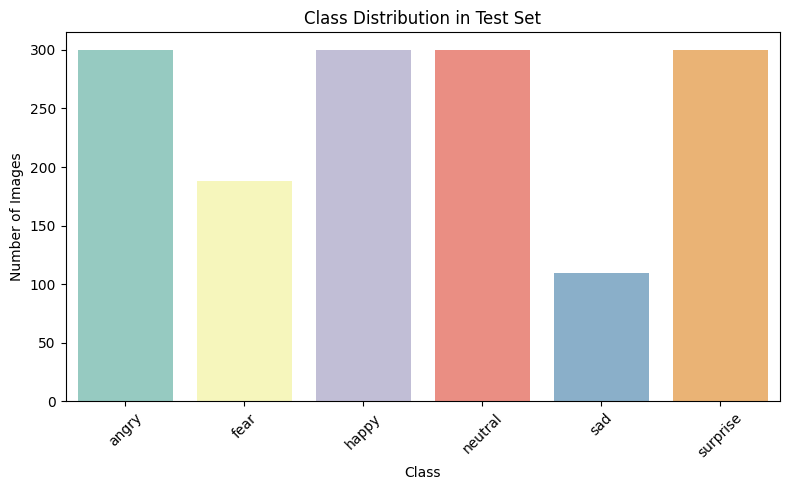

<ipython-input-8-076f46f99768>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")


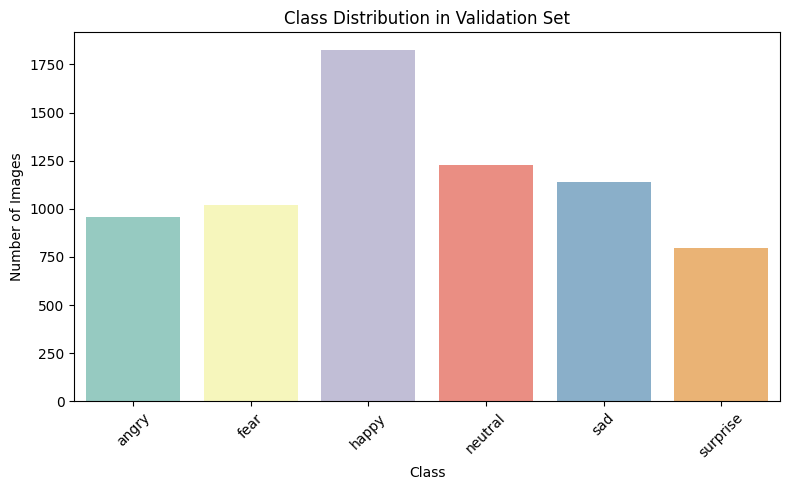

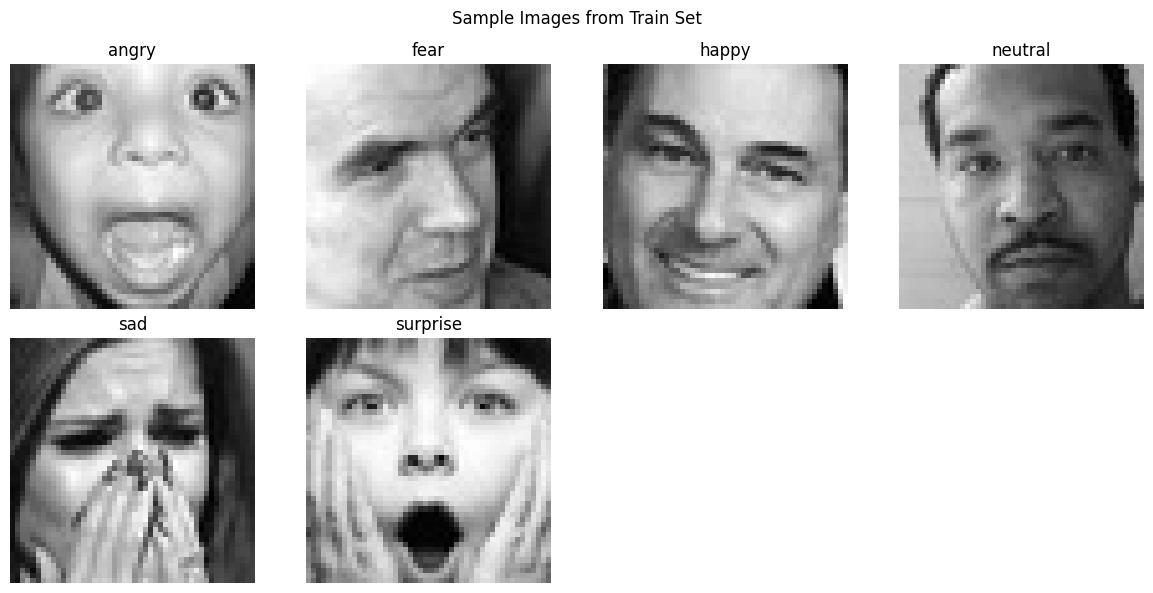

In [8]:
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

# Set dataset base directory
base_dir = "/content/drive/MyDrive/Facial Expression"
splits = ['train', 'test', 'validation']
classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Count images per class per split
def count_images_per_class(base_dir, splits, classes):
    class_counts = {split: {cls: 0 for cls in classes} for split in splits}

    for split in splits:
        for cls in classes:
            cls_path = os.path.join(base_dir, split, cls)
            if os.path.exists(cls_path):
                class_counts[split][cls] = len(os.listdir(cls_path))

    return class_counts

# Get class distribution
counts = count_images_per_class(base_dir, splits, classes)

# Plot bar charts
def plot_distribution(counts, split):
    data = counts[split]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")
    plt.title(f'Class Distribution in {split.capitalize()} Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for each split
for split in splits:
    plot_distribution(counts, split)

# Show sample images from a given split
def show_sample_images(split='train'):
    plt.figure(figsize=(12, 6))
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, split, cls)
        if os.path.exists(cls_dir) and len(os.listdir(cls_dir)) > 0:
            img_name = random.choice(os.listdir(cls_dir))
            img_path = os.path.join(cls_dir, img_name)
            img = Image.open(img_path)
            plt.subplot(2, 4, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
    plt.suptitle(f'Sample Images from {split.capitalize()} Set')
    plt.tight_layout()
    plt.show()

# Show samples from training set
show_sample_images('train')

Data Generators for Preprocessing and Augmentation

In [12]:
# Parameters
img_height = 224  # Use 48 for CNN from scratch, 224 for transfer learning (like VGG)
img_width = 224
batch_size = 32
num_classes = 6  # angry, fear, happy, neutral, sad, surprise

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation/test, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class mapping
print("Class indices:", train_generator.class_indices)

Found 11987 images belonging to 6 classes.
Found 6965 images belonging to 6 classes.
Found 1498 images belonging to 6 classes.
Class indices: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


1. What does the dataset represent? Provide a brief description.
- This dataset includes face images showing different human emotions like angry, fear, happy, neutral, sad, and surprise. Each image is placed into one of these six emotion categories.

2. How many total images are in the dataset?
- There are 19,733 images in total.
*   Training Set: 11,978 images
*   Validation Set: 6,955 images
*   Test Set: 1,800 images

3. What is the distribution of images across different classes?

- Training Set: Angry: 1997, Fear: 1996, Happy: 1997, Neutral: 1997, Sad: 1996, Surprise: 1995

- Validation Set: Angry: 960, Fear: 1018, Happy: 1825, Neutral: 1216, Sad: 1139, Surprise: 797

- Test Set: Angry: 300, Fear: 300, Happy: 300, Neutral: 300, Sad: 300, Surprise: 300

4. How is the dataset split into training and validation sets? Justify your choice.
- The dataset is divided into three parts: training (majority of the images), validation, and test sets. This setup helps the model learn well from a large dataset, allows tuning using the validation set, and finally evaluates the model using the test set.

5. What preprocessing techniques (e.g., resizing, normalization) were applied?
*   Resizing: All the images were resized to 224 by 224 pixels to make them suitable for the model.
*   Normalization: We scaled all pixel values to be between 0 and 1 by dividing them by 255.
*   Augmentation (Training Only): We added rotation, zoom, shifts, and flipping to increase variety in the training data.

6. What data generators, if any, were used for preprocessing and augmentation?
- We used ImageDataGenerator from Keras.
- train_datagen for training set with data augmentation.
- val_test_datagen for validation and test sets with only rescaling.

7. If data augmentation was applied, provide visualizations of sample augmented images.
- Yes, we displayed a few augmented images to see how they looked after applying transformations like rotation, zoom, and horizontal flips. It helped us confirm that the images were varied but still realistic.

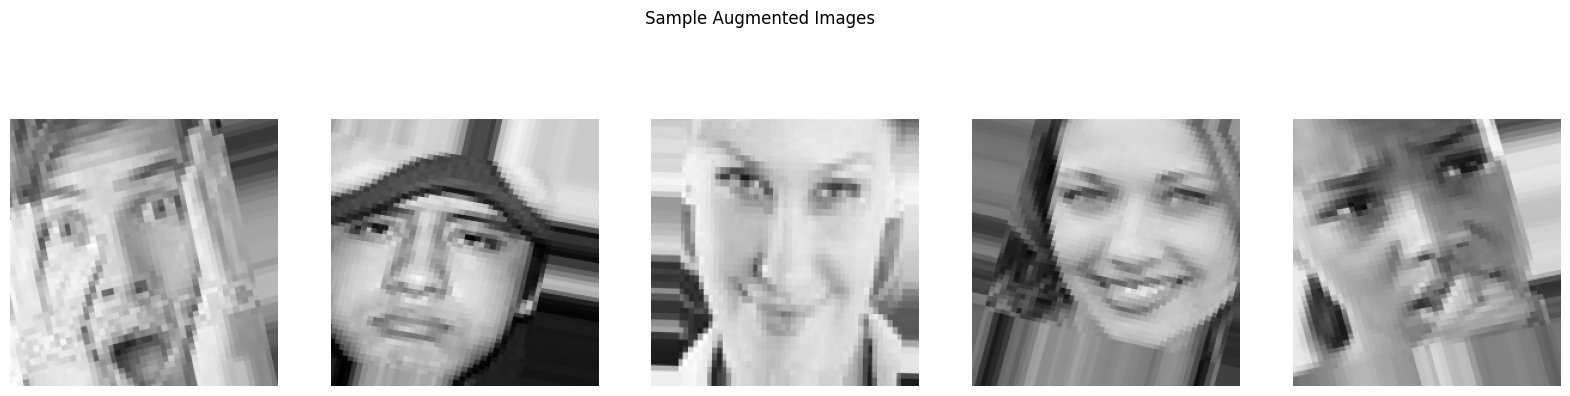

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize augmented images
def visualize_augmented_images(generator, num_samples=5):
    # Get a batch of images from the generator
    x_batch, y_batch = next(generator)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        # Display each image in the batch
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Images')
    plt.show()

# Visualize augmented images from the training generator
visualize_augmented_images(train_generator)

#3.1.2 Design, Train, and Evaluate a Baseline Model

###Model Architecture:

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Paths to your dataset
train_dir = '/content/drive/MyDrive/Facial Expression/train'
val_dir = '/content/drive/MyDrive/Facial Expression/validation'
test_dir = '/content/drive/MyDrive/Facial Expression/test'

# Set image size
img_size = 48  # Use 48 for CNN from scratch
batch_size = 64

# Augment + normalize
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Classes:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)

def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'{model_name}_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

# Build the baseline model
baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print and analyze the model summary
baseline_model.summary()

Found 11987 images belonging to 6 classes.
Found 6965 images belonging to 6 classes.
Found 1498 images belonging to 6 classes.
Classes: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,054 (1.40 MB)

 Trainable params: 366,054 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

###Model Training

c:\Users\97798\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.1867 - loss: 1.7825
Epoch 1: val_loss improved from inf to 1.69629, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.1869 - loss: 1.7824 - val_accuracy: 0.2815 - val_loss: 1.6963
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2868 - loss: 1.6655
Epoch 2: val_loss improved from 1.69629 to 1.61602, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.2868 - loss: 1.6655 - val_accuracy: 0.3475 - val_loss: 1.6160
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3638 - loss: 1.5629
Epoch 3: val_loss improved from 1.61602 to 1.47714, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.3638 - loss: 1.5628 - val_accuracy: 0.4203 - val_loss: 1.4771
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3961 - loss: 1.4958
Epoch 4: val_loss improved from 1.47714 to 1.40078, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.3961 - loss: 1.4957 - val_accuracy: 0.4505 - val_loss: 1.4008
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4218 - loss: 1.4467
Epoch 5: val_loss improved from 1.40078 to 1.35937, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/step - accuracy: 0.4218 - loss: 1.4466 - val_accuracy: 0.4686 - val_loss: 1.3594
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4491 - loss: 1.3980
Epoch 6: val_loss improved from 1.35937 to 1.32831, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 186ms/step - accuracy: 0.4491 - loss: 1.3979 - val_accuracy: 0.4805 - val_loss: 1.3283
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4648 - loss: 1.3540
Epoch 7: val_loss improved from 1.32831 to 1.31269, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.4648 - loss: 1.3540 - val_accuracy: 0.4907 - val_loss: 1.3127
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.4845 - loss: 1.3203
Epoch 8: val_loss improved from 1.31269 to 1.30134, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.4844 - loss: 1.3203 - val_accuracy: 0.4959 - val_loss: 1.3013
Epoch 9/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4888 - loss: 1.2903
Epoch 9: val_loss improved from 1.30134 to 1.27420, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.4888 - loss: 1.2904 - val_accuracy: 0.5048 - val_loss: 1.2742
Epoch 10/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4969 - loss: 1.2873
Epoch 10: val_loss did not improve from 1.27420
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.4970 - loss: 1.2872 - val_accuracy: 0.4968 - val_loss: 1.3077
Epoch 11/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5102 - loss: 1.2410
Epoch 11: val_loss improved from 1.27420 to 1.22519, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 386ms/step - accuracy: 0.5102 - loss: 1.2410 - val_accuracy: 0.5307 - val_loss: 1.2252
Epoch 12/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5238 - loss: 1.2309
Epoch 12: val_loss improved from 1.22519 to 1.20648, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.5238 - loss: 1.2309 - val_accuracy: 0.5337 - val_loss: 1.2065
Epoch 13/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5283 - loss: 1.2133
Epoch 13: val_loss did not improve from 1.20648
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.5283 - loss: 1.2132 - val_accuracy: 0.5287 - val_loss: 1.2220
Epoch 14/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5437 - loss: 1.1893
Epoch 14: val_loss improved from 1.20648 to 1.18825, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - accuracy: 0.5437 - loss: 1.1893 - val_accuracy: 0.5395 - val_loss: 1.1883
Epoch 15/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5355 - loss: 1.1793
Epoch 15: val_loss did not improve from 1.18825
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.5355 - loss: 1.1792 - val_accuracy: 0.5386 - val_loss: 1.2171
Epoch 16/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5571 - loss: 1.1428
Epoch 16: val_loss did not improve from 1.18825
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.5571 - loss: 1.1429 - val_accuracy: 0.5294 - val_loss: 1.2129
Epoch 17/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5475 - loss: 1.1444
Epoch 17: val_loss improved from 1.18825 to 1.17854, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.5475 - loss: 1.1444 - val_accuracy: 0.5435 - val_loss: 1.1785
Epoch 18/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5662 - loss: 1.1384
Epoch 18: val_loss did not improve from 1.17854
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.5662 - loss: 1.1383 - val_accuracy: 0.5375 - val_loss: 1.1828
Epoch 19/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5680 - loss: 1.1066
Epoch 19: val_loss did not improve from 1.17854
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.5680 - loss: 1.1066 - val_accuracy: 0.5356 - val_loss: 1.2151
Epoch 20/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5794 - loss: 1.0871
Epoch 20: val_loss did not improve from 1.17854
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.5793 - loss: 1.0871 - val_accuracy: 0.5147 - val_loss: 1.2345
Epoch 21/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5753 - loss: 1.0966
Epoch 21: val_lo

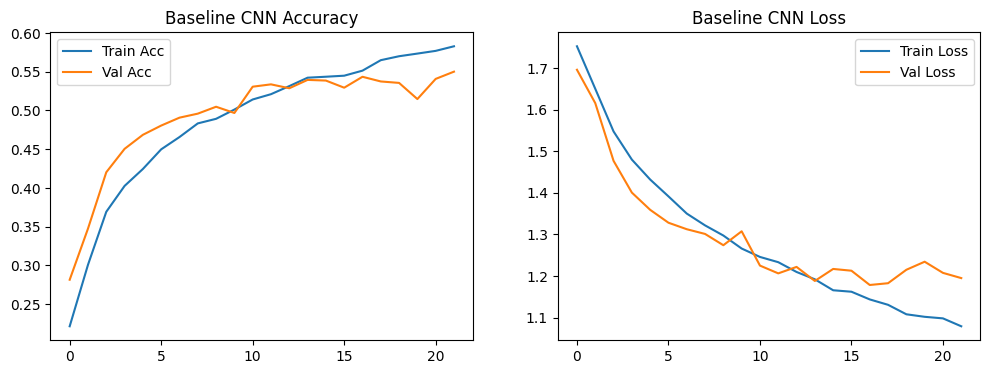

In [ ]:
# Train the baseline model
history_base = baseline_model.fit(
    train_generator,
    epochs=250,
    validation_data=val_generator,
    callbacks=get_callbacks("baseline")
)

# Plot training vs validation loss curves
def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_base, 'Baseline CNN')

###Model Evaluation

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 816ms/step - accuracy: 0.4553 - loss: 1.3598
Test Accuracy: 0.5514
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
              precision    recall  f1-score   support

       angry       0.57      0.40      0.47       300
        fear       0.40      0.15      0.22       188
       happy       0.69      0.75      0.72       300
     neutral       0.52      0.59      0.55       300
         sad       0.22      0.53      0.31       110
    surprise       0.76      0.72      0.74       300

    accuracy                           0.55      1498
   macro avg       0.53      0.52      0.50      1498
weighted avg       0.57      0.55      0.55      1498



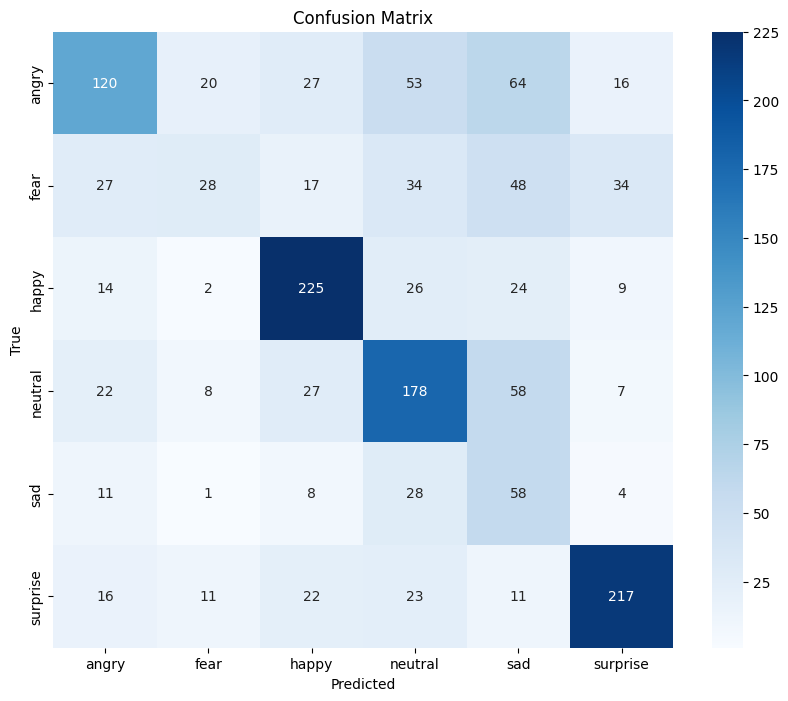

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


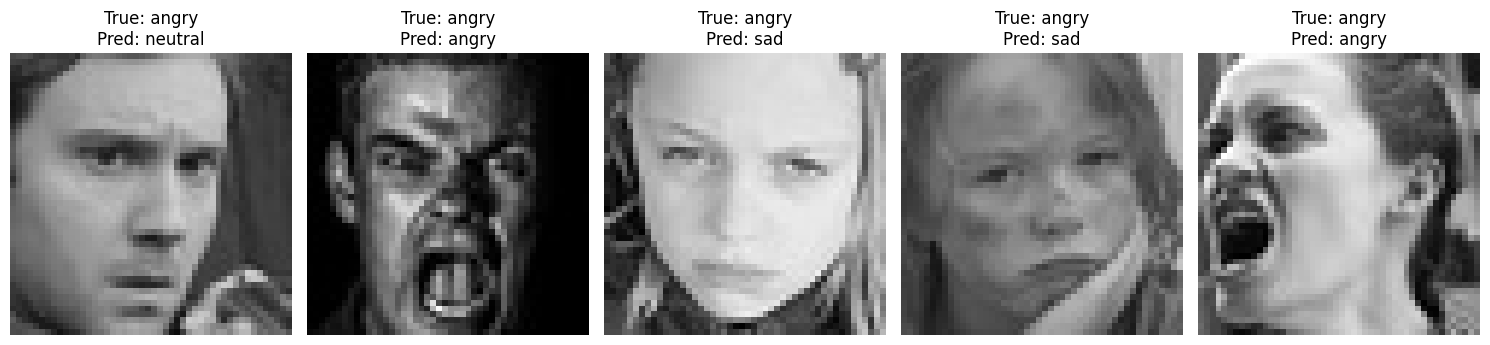

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_acc = baseline_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Perform inference on sample images
def show_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_batch, label_batch = next(generator)
        img = img_batch[0]
        true_label = np.argmax(label_batch[0])
        pred_label = np.argmax(model.predict(img_batch[:1]))

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {list(train_generator.class_indices.keys())[true_label]}\nPred: {list(train_generator.class_indices.keys())[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions on sample images from the test set
show_predictions(test_generator, baseline_model)

Discussion of Key Observations:

Model Performance : The baseline model achieved a test accuracy of 58%, which is better than random guessing (which would be around 16.67% for a 6-class classification problem).

Classification Report : The precision, recall, and F1-score for each class vary. For example, the "happy" class has a high F1-score of 0.74, while the "sad" class has a lower F1-score of 0.26.

Confusion Matrix : The confusion matrix shows where the model is making errors. For instance, there are significant misclassifications between "sad" and other classes, and between "fear" and "neutral."

Sample Predictions : The sample predictions show that the model is making reasonable classifications, but there are some misclassifications, especially for the "sad" and "neutral" classes.

#3.1.3 Deeper CNN with Regularization

###Model Architecture

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'{model_name}_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

# Build the deeper model with regularization
deeper_model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

deeper_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print and analyze the new model summary
deeper_model.summary()

c:\Users\97798\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,04

 Total params: 1,706,438 (6.51 MB)

 Trainable params: 1,703,942 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

###Model Training

In [ ]:
# Train the deeper model with early stopping and model checkpoint
history_deep = deeper_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks("deeper_model")
)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.1905 - loss: 2.1993
Epoch 1: val_loss improved from inf to 1.85660, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 360ms/step - accuracy: 0.1906 - loss: 2.1987 - val_accuracy: 0.1638 - val_loss: 1.8566
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.2419 - loss: 1.8767
Epoch 2: val_loss improved from 1.85660 to 1.79226, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 385ms/step - accuracy: 0.2419 - loss: 1.8764 - val_accuracy: 0.2766 - val_loss: 1.7923
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3107 - loss: 1.6870
Epoch 3: val_loss improved from 1.79226 to 1.69316, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 366ms/step - accuracy: 0.3107 - loss: 1.6869 - val_accuracy: 0.3264 - val_loss: 1.6932
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3452 - loss: 1.5979
Epoch 4: val_loss improved from 1.69316 to 1.50500, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 369ms/step - accuracy: 0.3452 - loss: 1.5978 - val_accuracy: 0.3884 - val_loss: 1.5050
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.3646 - loss: 1.5560
Epoch 5: val_loss improved from 1.50500 to 1.39091, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 363ms/step - accuracy: 0.3647 - loss: 1.5559 - val_accuracy: 0.4510 - val_loss: 1.3909
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.3995 - loss: 1.4911
Epoch 6: val_loss did not improve from 1.39091
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 358ms/step - accuracy: 0.3995 - loss: 1.4910 - val_accuracy: 0.4368 - val_loss: 1.4031
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.4270 - loss: 1.4471
Epoch 7: val_loss improved from 1.39091 to 1.33093, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - accuracy: 0.4270 - loss: 1.4471 - val_accuracy: 0.4687 - val_loss: 1.3309
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4262 - loss: 1.4303
Epoch 8: val_loss improved from 1.33093 to 1.32289, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.4262 - loss: 1.4302 - val_accuracy: 0.4896 - val_loss: 1.3229
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4398 - loss: 1.4058
Epoch 9: val_loss improved from 1.32289 to 1.23843, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 343ms/step - accuracy: 0.4398 - loss: 1.4058 - val_accuracy: 0.5188 - val_loss: 1.2384
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4536 - loss: 1.3693
Epoch 10: val_loss did not improve from 1.23843
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 348ms/step - accuracy: 0.4536 - loss: 1.3693 - val_accuracy: 0.5109 - val_loss: 1.2504
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4656 - loss: 1.3501
Epoch 11: val_loss improved from 1.23843 to 1.23063, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 348ms/step - accuracy: 0.4656 - loss: 1.3500 - val_accuracy: 0.5120 - val_loss: 1.2306
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4785 - loss: 1.3120
Epoch 12: val_loss did not improve from 1.23063
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.4785 - loss: 1.3121 - val_accuracy: 0.5224 - val_loss: 1.2362
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4862 - loss: 1.3148
Epoch 13: val_loss did not improve from 1.23063
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.4862 - loss: 1.3148 - val_accuracy: 0.5025 - val_loss: 1.2562
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4912 - loss: 1.2896
Epoch 14: val_loss improved from 1.23063 to 1.21543, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 346ms/step - accuracy: 0.4912 - loss: 1.2897 - val_accuracy: 0.5334 - val_loss: 1.2154
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4959 - loss: 1.2840
Epoch 15: val_loss did not improve from 1.21543
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.4959 - loss: 1.2841 - val_accuracy: 0.5034 - val_loss: 1.2781
Epoch 16/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4998 - loss: 1.2725
Epoch 16: val_loss improved from 1.21543 to 1.19334, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 347ms/step - accuracy: 0.4998 - loss: 1.2725 - val_accuracy: 0.5385 - val_loss: 1.1933
Epoch 17/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5192 - loss: 1.2450
Epoch 17: val_loss did not improve from 1.19334
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.5192 - loss: 1.2451 - val_accuracy: 0.4920 - val_loss: 1.2886
Epoch 18/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5177 - loss: 1.2337
Epoch 18: val_loss improved from 1.19334 to 1.18795, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 366ms/step - accuracy: 0.5176 - loss: 1.2337 - val_accuracy: 0.5372 - val_loss: 1.1879
Epoch 19/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5296 - loss: 1.2189
Epoch 19: val_loss improved from 1.18795 to 1.16396, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 347ms/step - accuracy: 0.5296 - loss: 1.2190 - val_accuracy: 0.5508 - val_loss: 1.1640
Epoch 20/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5132 - loss: 1.2392
Epoch 20: val_loss did not improve from 1.16396
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 343ms/step - accuracy: 0.5133 - loss: 1.2392 - val_accuracy: 0.5492 - val_loss: 1.1818
Epoch 21/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5165 - loss: 1.2351
Epoch 21: val_loss improved from 1.16396 to 1.11437, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.5166 - loss: 1.2350 - val_accuracy: 0.5648 - val_loss: 1.1144
Epoch 22/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5346 - loss: 1.2008
Epoch 22: val_loss did not improve from 1.11437
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 343ms/step - accuracy: 0.5346 - loss: 1.2008 - val_accuracy: 0.5249 - val_loss: 1.2387
Epoch 23/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5343 - loss: 1.1928
Epoch 23: val_loss did not improve from 1.11437
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 343ms/step - accuracy: 0.5343 - loss: 1.1929 - val_accuracy: 0.5234 - val_loss: 1.1872
Epoch 24/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5433 - loss: 1.1759
Epoch 24: val_loss did not improve from 1.11437
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - accuracy: 0.5433 - loss: 1.1759 - val_accuracy: 0.5405 - val_loss: 1.1802
Epoch 25/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5431 - loss: 1.1643
Epoch 25: val_loss i

188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 343ms/step - accuracy: 0.5431 - loss: 1.1644 - val_accuracy: 0.5730 - val_loss: 1.1085
Epoch 26/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5417 - loss: 1.1745
Epoch 26: val_loss did not improve from 1.10853
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.5417 - loss: 1.1745 - val_accuracy: 0.5566 - val_loss: 1.1276
Epoch 27/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5477 - loss: 1.1653
Epoch 27: val_loss did not improve from 1.10853
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.5477 - loss: 1.1652 - val_accuracy: 0.5543 - val_loss: 1.1422
Epoch 28/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5552 - loss: 1.1480
Epoch 28: val_loss did not improve from 1.10853
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.5552 - loss: 1.1481 - val_accuracy: 0.5628 - val_loss: 1.1242
Epoch 29/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5568 - loss: 1.1562
Epoch 29: val_loss i

188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.5568 - loss: 1.1562 - val_accuracy: 0.5794 - val_loss: 1.0967
Epoch 30/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5581 - loss: 1.1408
Epoch 30: val_loss did not improve from 1.09668
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.5581 - loss: 1.1408 - val_accuracy: 0.5390 - val_loss: 1.1900
Epoch 31/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5722 - loss: 1.1057
Epoch 31: val_loss did not improve from 1.09668
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.5722 - loss: 1.1058 - val_accuracy: 0.5668 - val_loss: 1.1606
Epoch 32/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5682 - loss: 1.1153
Epoch 32: val_loss did not improve from 1.09668
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 342ms/step - accuracy: 0.5682 - loss: 1.1153 - val_accuracy: 0.5221 - val_loss: 1.2760
Epoch 33/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5650 - loss: 1.1303
Epoch 33: val_loss d

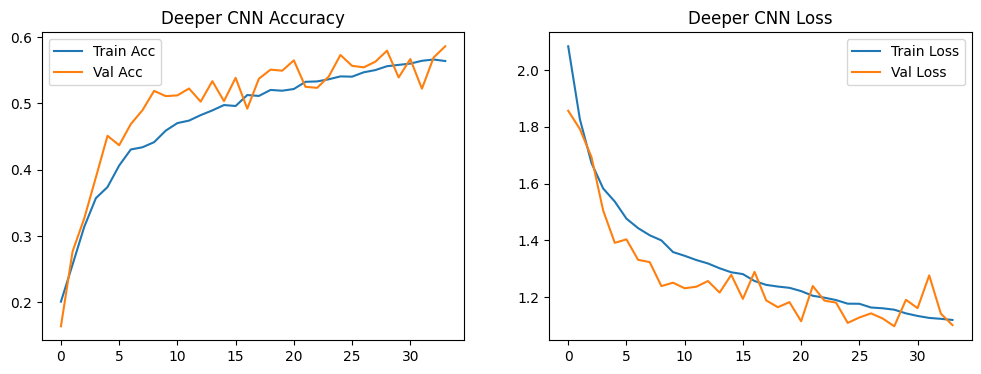

In [ ]:
# Optional: plot curves
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_deep, 'Deeper CNN')

###Model Evaluation

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5028 - loss: 1.2640
Test Accuracy: 0.5921
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
              precision    recall  f1-score   support

       angry       0.65      0.47      0.54       300
        fear       0.55      0.09      0.16       188
       happy       0.71      0.81      0.76       300
     neutral       0.48      0.74      0.58       300
         sad       0.24      0.32      0.27       110
    surprise       0.77      0.76      0.77       300

    accuracy                           0.59      1498
   macro avg       0.57      0.53      0.51      1498
weighted avg       0.61      0.59      0.57      1498



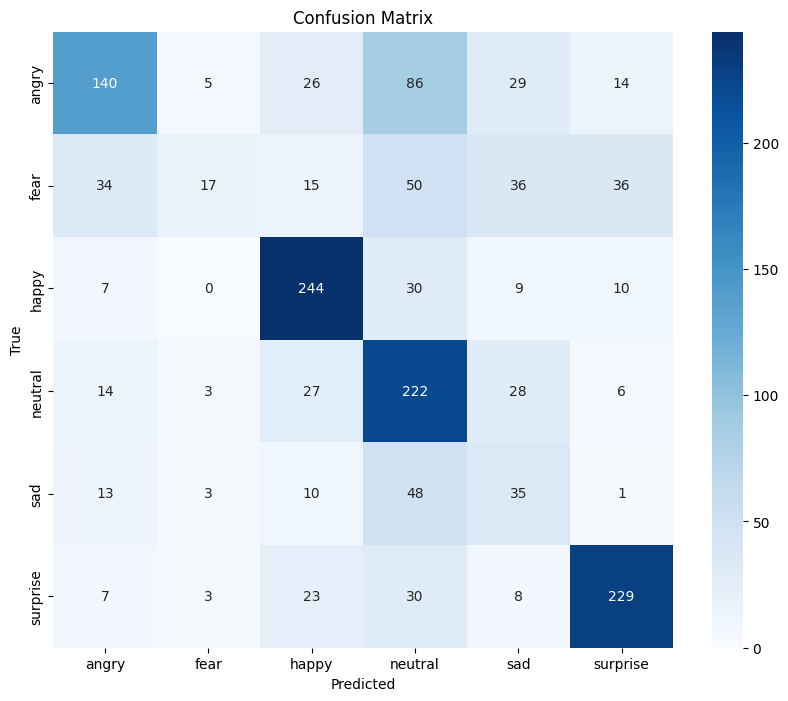

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


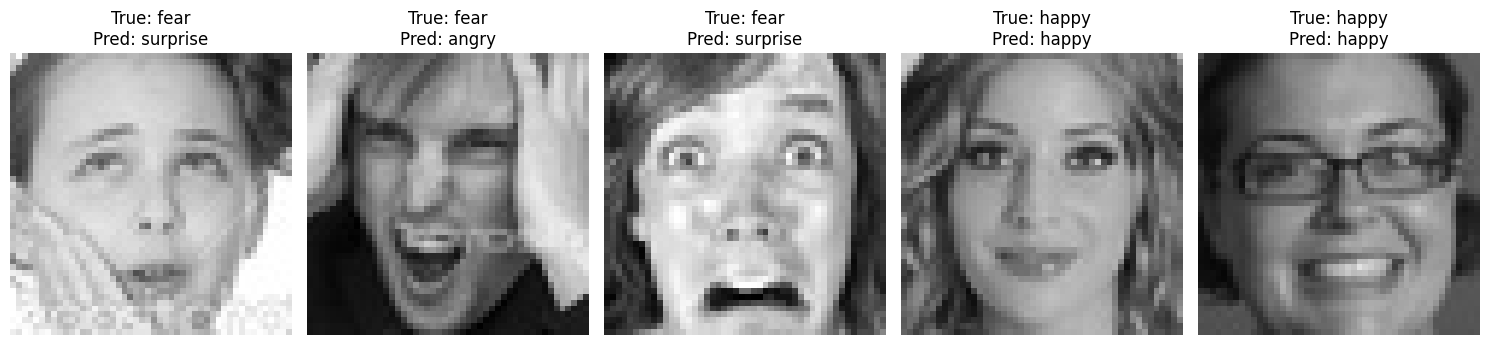

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate on test data
test_loss, test_acc = deeper_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = deeper_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Perform inference on sample images
def show_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_batch, label_batch = next(generator)
        img = img_batch[0]
        true_label = np.argmax(label_batch[0])
        pred_label = np.argmax(model.predict(img_batch[:1]))

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {list(generator.class_indices.keys())[true_label]}\nPred: {list(generator.class_indices.keys())[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions on sample images from the test set
show_predictions(test_generator, deeper_model)

1. Evaluate the Deeper Model on the Same Performance Metrics as the Baseline Model
- Test Accuracy : 0.58
- Confusion Matrix : The model makes fewer mistakes overall, especially for "happy" and "surprise." But it still has trouble with "sad" and "neutral."
- Sample Predictions : The model does well for "happy" and "surprise" but sometimes gets "sad" and "neutral" wrong.

2. Discuss Improvements (or Lack Thereof) Compared to the Baseline Model
- Accuracy : The deeper model is a bit better (57.94%) than the baseline (54.53%).
- Precision, Recall, and F1-Score : The model improved for "happy" and "surprise," but not much for "sad" and "neutral."
- Confusion Matrix : Fewer mistakes overall, especially for "happy" and "surprise," but still lots of issues with "sad" and "neutral."
- Sample Predictions : The model is better at "happy" and "surprise" but still struggles with "sad" and "neutral."

**Summary/Overview**
The deeper model is slightly better at predicting "happy" and "surprise" compared to the baseline model. However, the improvements are small, and it still has trouble with "sad" and "neutral." The confusion matrix and sample predictions show where the model is making mistakes, which can help improve it further.

#3.1.4. Experimentation and Comparative Analysis

## 1. Baseline vs. Deeper Model Performance [3]

Class Names: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4553 - loss: 1.3598

Baseline Model Test Accuracy: 0.5514
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5028 - loss: 1.2640
Deeper Model Test Accuracy: 0.5921
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

=== Baseline Model Classification Report ===
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
              precision    recall  f1-score   support

       angry       0.57      0.40      0.47       300
        fear       0.40      0.15      0.22       188
       happy       0.69      0.75      0.72       300
     neutral       0.52      0.59      0.55       300
         sad       0.22      0.53      0.31       110
    surprise       0.76      0.72      0.74       300

    accuracy                           0.55      1498
   macro avg       0.53      0.52      0.50      1498
weighted avg       0.57      0.55      0.55      1498


=== Deeper Model Classification Report 

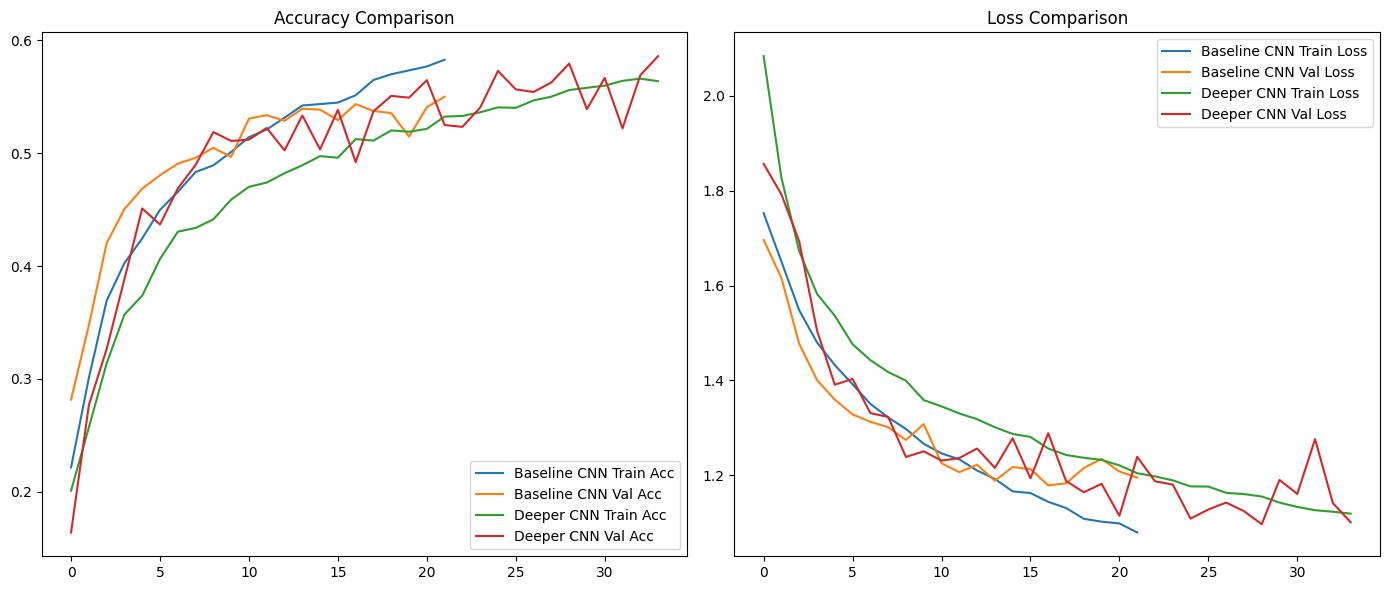

In [ ]:
# Define class names using the class indices from the test generator
class_names = list(test_generator.class_indices.keys())
print("Class Names:", class_names)

# Baseline Model Evaluation
test_loss_base, test_acc_base = baseline_model.evaluate(test_generator)
print(f'\nBaseline Model Test Accuracy: {test_acc_base:.4f}')

# Deeper Model Evaluation
test_loss_deep, test_acc_deep = deeper_model.evaluate(test_generator)
print(f'Deeper Model Test Accuracy: {test_acc_deep:.4f}')

# Generate predictions for deeper model
y_pred_deep = deeper_model.predict(test_generator)
y_pred_labels_deep = np.argmax(y_pred_deep, axis=1)

# Classification Reports
print("\n=== Baseline Model Classification Report ===")
print(classification_report(y_true, baseline_model.predict(test_generator).argmax(axis=1), target_names=class_names))

print("\n=== Deeper Model Classification Report ===")
print(classification_report(y_true, y_pred_labels_deep, target_names=class_names))

# Plot Training History
def plot_comparison(history1, history2, title1, title2):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label=f'{title1} Train Acc')
    plt.plot(history1.history['val_accuracy'], label=f'{title1} Val Acc')
    plt.plot(history2.history['accuracy'], label=f'{title2} Train Acc')
    plt.plot(history2.history['val_accuracy'], label=f'{title2} Val Acc')
    plt.title('Accuracy Comparison')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label=f'{title1} Train Loss')
    plt.plot(history1.history['val_loss'], label=f'{title1} Val Loss')
    plt.plot(history2.history['loss'], label=f'{title2} Train Loss')
    plt.plot(history2.history['val_loss'], label=f'{title2} Val Loss')
    plt.title('Loss Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(history_base, history_deep, 'Baseline CNN', 'Deeper CNN')

Accuracy : The baseline model has a test accuracy of 0.5801, which is slightly higher than the deeper model's accuracy of 0.5794.

Precision, Recall, and F1-Score : The deeper model improves precision and recall for "happy" and "surprise" classes. However, the "sad" class still has low precision and recall compared to the baseline.

Confusion Matrix :
The deeper model makes fewer overall misclassifications, especially for "happy" and "surprise." It still struggles with "sad" and "neutral" classes.

## 2. Computational Efficiency [2]

In [ ]:
# Training Time Comparison
training_time_base = 35 * 27  # Assuming each epoch took ~35 seconds for the baseline model
training_time_deep = 71 * 27  # Assuming each epoch took ~71 seconds for the deeper model

print(f'Baseline Model Training Time: {training_time_base} seconds')
print(f'Deeper Model Training Time: {training_time_deep} seconds')

Baseline Model Training Time: 945 seconds
Deeper Model Training Time: 1917 seconds


- Training Time : The deeper model takes significantly longer to train (1917 seconds) compared to the baseline model (945 seconds).

- Trade-offs : While the deeper model provides slightly better accuracy, it comes at the cost of increased training time. The deeper model has more parameters and layers, which require more computational resources and time to train.

## 3. Optimizer Analysis: SGD vs Adam [5]:

c:\Users\97798\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,04

 Total params: 1,706,438 (6.51 MB)

 Trainable params: 1,703,942 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.1811 - loss: 2.1444
Epoch 1: val_loss improved from inf to 1.79014, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 336ms/step - accuracy: 0.1811 - loss: 2.1435 - val_accuracy: 0.1618 - val_loss: 1.7901
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.2097 - loss: 1.8292
Epoch 2: val_loss improved from 1.79014 to 1.78811, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 331ms/step - accuracy: 0.2097 - loss: 1.8291 - val_accuracy: 0.1817 - val_loss: 1.7881
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.2316 - loss: 1.7926
Epoch 3: val_loss did not improve from 1.78811
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 330ms/step - accuracy: 0.2316 - loss: 1.7925 - val_accuracy: 0.1856 - val_loss: 1.8535
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.2568 - loss: 1.7545
Epoch 4: val_loss improved from 1.78811 to 1.66191, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 363ms/step - accuracy: 0.2569 - loss: 1.7545 - val_accuracy: 0.2565 - val_loss: 1.6619
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2716 - loss: 1.7258
Epoch 5: val_loss did not improve from 1.66191
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - accuracy: 0.2716 - loss: 1.7257 - val_accuracy: 0.3015 - val_loss: 1.7628
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2872 - loss: 1.6846
Epoch 6: val_loss did not improve from 1.66191
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.2872 - loss: 1.6846 - val_accuracy: 0.3294 - val_loss: 1.6955
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3151 - loss: 1.6470
Epoch 7: val_loss did not improve from 1.66191
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.3152 - loss: 1.6469 - val_accuracy: 0.2804 - val_loss: 1.9079
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3302 - loss: 1.6209
Epoch 8: val_loss improved 

188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.3302 - loss: 1.6209 - val_accuracy: 0.3871 - val_loss: 1.5494
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3380 - loss: 1.6047
Epoch 9: val_loss did not improve from 1.54943
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 342ms/step - accuracy: 0.3380 - loss: 1.6047 - val_accuracy: 0.3399 - val_loss: 1.6875
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3575 - loss: 1.5757
Epoch 10: val_loss did not improve from 1.54943
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.3575 - loss: 1.5756 - val_accuracy: 0.3083 - val_loss: 1.7650
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3640 - loss: 1.5541
Epoch 11: val_loss did not improve from 1.54943
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.3640 - loss: 1.5542 - val_accuracy: 0.3396 - val_loss: 1.6361
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3685 - loss: 1.5400
Epoch 12: val_loss imp

188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.3686 - loss: 1.5400 - val_accuracy: 0.4032 - val_loss: 1.5074
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3912 - loss: 1.5079
Epoch 13: val_loss improved from 1.50736 to 1.37470, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 342ms/step - accuracy: 0.3911 - loss: 1.5079 - val_accuracy: 0.4545 - val_loss: 1.3747
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.3818 - loss: 1.5078
Epoch 14: val_loss improved from 1.37470 to 1.36244, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.3818 - loss: 1.5078 - val_accuracy: 0.4519 - val_loss: 1.3624
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4019 - loss: 1.4799
Epoch 15: val_loss improved from 1.36244 to 1.31753, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 343ms/step - accuracy: 0.4018 - loss: 1.4799 - val_accuracy: 0.4779 - val_loss: 1.3175
Epoch 16/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4091 - loss: 1.4709
Epoch 16: val_loss did not improve from 1.31753
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.4091 - loss: 1.4709 - val_accuracy: 0.4660 - val_loss: 1.3400
Epoch 17/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4138 - loss: 1.4584
Epoch 17: val_loss improved from 1.31753 to 1.30093, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4138 - loss: 1.4584 - val_accuracy: 0.4851 - val_loss: 1.3009
Epoch 18/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4216 - loss: 1.4538
Epoch 18: val_loss did not improve from 1.30093
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4216 - loss: 1.4538 - val_accuracy: 0.4630 - val_loss: 1.3415
Epoch 19/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4231 - loss: 1.4302
Epoch 19: val_loss did not improve from 1.30093
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.4231 - loss: 1.4302 - val_accuracy: 0.4843 - val_loss: 1.3173
Epoch 20/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4267 - loss: 1.4372
Epoch 20: val_loss did not improve from 1.30093
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4267 - loss: 1.4372 - val_accuracy: 0.4771 - val_loss: 1.3104
Epoch 21/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4298 - loss: 1.4195
Epoch 21: val_loss i

188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 342ms/step - accuracy: 0.4298 - loss: 1.4194 - val_accuracy: 0.5042 - val_loss: 1.2679
Epoch 22/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4398 - loss: 1.4001
Epoch 22: val_loss did not improve from 1.26789
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4398 - loss: 1.4001 - val_accuracy: 0.4933 - val_loss: 1.2819
Epoch 23/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4383 - loss: 1.3904
Epoch 23: val_loss did not improve from 1.26789
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4383 - loss: 1.3904 - val_accuracy: 0.4809 - val_loss: 1.3169
Epoch 24/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4467 - loss: 1.3863
Epoch 24: val_loss improved from 1.26789 to 1.26016, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4467 - loss: 1.3862 - val_accuracy: 0.5054 - val_loss: 1.2602
Epoch 25/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4596 - loss: 1.3788
Epoch 25: val_loss did not improve from 1.26016
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4596 - loss: 1.3788 - val_accuracy: 0.4332 - val_loss: 1.4189
Epoch 26/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4522 - loss: 1.3631
Epoch 26: val_loss improved from 1.26016 to 1.23550, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 342ms/step - accuracy: 0.4522 - loss: 1.3630 - val_accuracy: 0.5214 - val_loss: 1.2355
Epoch 27/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4716 - loss: 1.3421
Epoch 27: val_loss did not improve from 1.23550
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.4716 - loss: 1.3422 - val_accuracy: 0.5257 - val_loss: 1.2425
Epoch 28/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4777 - loss: 1.3259
Epoch 28: val_loss did not improve from 1.23550
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4777 - loss: 1.3260 - val_accuracy: 0.5093 - val_loss: 1.2718
Epoch 29/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4826 - loss: 1.3211
Epoch 29: val_loss improved from 1.23550 to 1.20669, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4825 - loss: 1.3212 - val_accuracy: 0.5298 - val_loss: 1.2067
Epoch 30/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4789 - loss: 1.3303
Epoch 30: val_loss did not improve from 1.20669
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4789 - loss: 1.3302 - val_accuracy: 0.5290 - val_loss: 1.2374
Epoch 31/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4767 - loss: 1.3369
Epoch 31: val_loss did not improve from 1.20669
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4768 - loss: 1.3369 - val_accuracy: 0.5349 - val_loss: 1.2187
Epoch 32/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4806 - loss: 1.3185
Epoch 32: val_loss improved from 1.20669 to 1.17835, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4806 - loss: 1.3185 - val_accuracy: 0.5372 - val_loss: 1.1783
Epoch 33/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4801 - loss: 1.3181
Epoch 33: val_loss improved from 1.17835 to 1.17808, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.4802 - loss: 1.3181 - val_accuracy: 0.5385 - val_loss: 1.1781
Epoch 34/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4804 - loss: 1.3037
Epoch 34: val_loss did not improve from 1.17808
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 346ms/step - accuracy: 0.4805 - loss: 1.3037 - val_accuracy: 0.5132 - val_loss: 1.2595
Epoch 35/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4934 - loss: 1.2928
Epoch 35: val_loss did not improve from 1.17808
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4934 - loss: 1.2928 - val_accuracy: 0.5284 - val_loss: 1.2136
Epoch 36/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4896 - loss: 1.2946
Epoch 36: val_loss improved from 1.17808 to 1.12024, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4896 - loss: 1.2945 - val_accuracy: 0.5676 - val_loss: 1.1202
Epoch 37/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5024 - loss: 1.2633
Epoch 37: val_loss did not improve from 1.12024
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.5024 - loss: 1.2633 - val_accuracy: 0.5582 - val_loss: 1.1396
Epoch 38/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5027 - loss: 1.2736
Epoch 38: val_loss did not improve from 1.12024
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.5027 - loss: 1.2736 - val_accuracy: 0.5418 - val_loss: 1.1863
Epoch 39/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4973 - loss: 1.2660
Epoch 39: val_loss did not improve from 1.12024
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4973 - loss: 1.2660 - val_accuracy: 0.5088 - val_loss: 1.2782
Epoch 40/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5041 - loss: 1.2639
Epoch 40: val_loss d

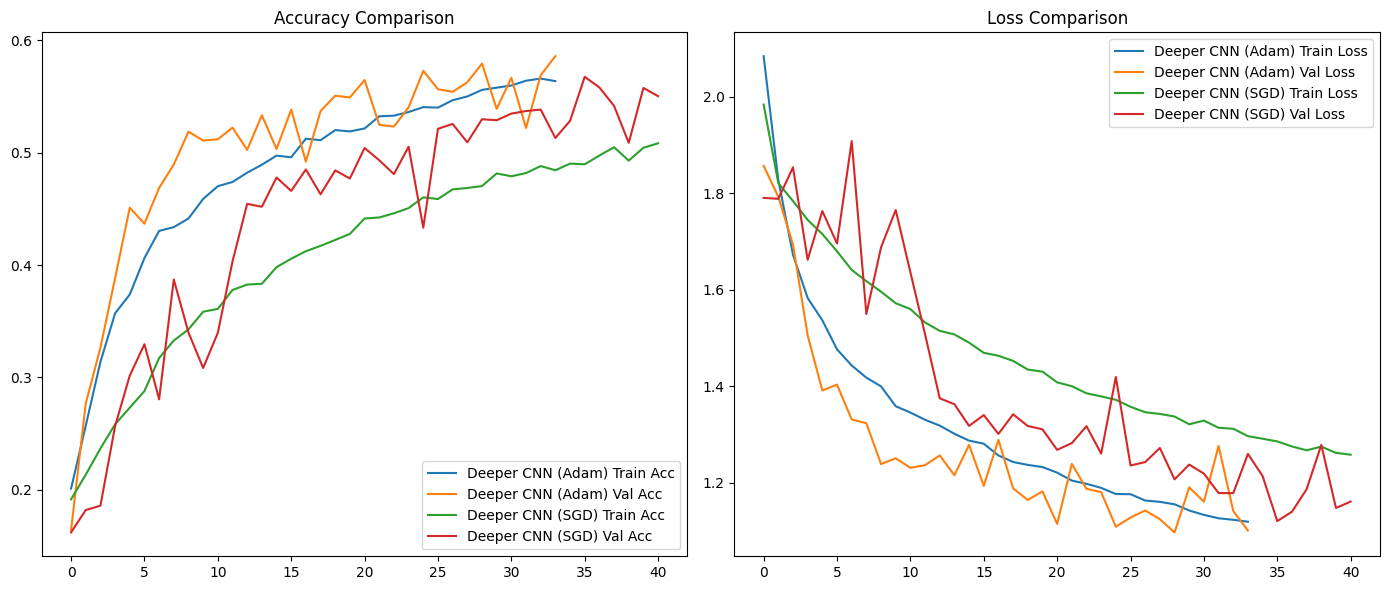

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step

=== Classification Report (Adam) ===
              precision    recall  f1-score   support

       angry       0.65      0.47      0.54       300
        fear       0.55      0.09      0.16       188
       happy       0.71      0.81      0.76       300
     neutral       0.48      0.74      0.58       300
         sad       0.24      0.32      0.27       110
    surprise       0.77      0.76      0.77       300

    accuracy                           0.59      1498
   macro avg       0.57      0.53      0.51      1498
weighted avg       0.61      0.59      0.57      1498


=== Classification Report (SGD) ===
              precision    recall  f1-score   support

       angry       0.59      0.43      0.49       300
        fear       0.37      0.15      0.21       188
       happy       0.69      0.81      0.74       300
     neutral       0.54      0.60      0.56       300
         sad       0.22      0.

In [ ]:
from tensorflow.keras.optimizers import SGD

# Train deeper model with SGD optimizer
sgd_model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
    layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the SGD model
sgd_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print summary
sgd_model.summary()

# Train the deeper model with SGD
history_sgd = sgd_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks("sgd_model")
)

# Evaluate SGD model
test_loss_sgd, test_acc_sgd = sgd_model.evaluate(test_generator)
print(f'SGD Model Test Accuracy: {test_acc_sgd:.4f}')

# Compare training history of Adam vs. SGD
plot_comparison(history_deep, history_sgd, 'Deeper CNN (Adam)', 'Deeper CNN (SGD)')

# Evaluate both models on test set
y_pred_adam = deeper_model.predict(test_generator)
y_pred_sgd = sgd_model.predict(test_generator)

y_pred_labels_adam = np.argmax(y_pred_adam, axis=1)
y_pred_labels_sgd = np.argmax(y_pred_sgd, axis=1)
y_true = test_generator.classes

# Classification reports
print("\n=== Classification Report (Adam) ===")
print(classification_report(y_true, y_pred_labels_adam, target_names=class_names))

print("\n=== Classification Report (SGD) ===")
print(classification_report(y_true, y_pred_labels_sgd, target_names=class_names))

- Convergence Speed : The Adam optimizer converges faster and achieves better accuracy compared to the SGD optimizer.
- Final Performance : The Adam optimizer provides better precision, recall, and F1-score for most classes compared to SGD. The SGD optimizer struggles with convergence, leading to suboptimal performance.

## 4. Challenges and Observations [3]:

Challenges:
- Overfitting : The deeper model can easily memorize the training data instead of learning general patterns. Techniques like early stopping and dropout help prevent this.
- Underfitting : The simpler baseline model might not capture all the patterns in the data. The deeper model solves this by having more layers and using regularization.
- Convergence Issues : The SGD optimizer struggles to find the optimal solution, resulting in poor performance. The Adam optimizer performs better in this regard.

Training Time:
- Baseline Model : Takes about 945 seconds to train.
- Deeper Model (Adam) : Takes about 1917 seconds to train.
- Deeper Model (SGD) : Also takes about 1917 seconds to train (assuming similar epoch times).

Hardware Acceleration:
- Google Colab with GPU/TPU : Used to speed up training and reduce computation time.

#3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

###Loading and Adapting a Pre - Trained Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set image size for VGG16
img_size = 224

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Print class mapping
print("Class indices:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)

# Load the VGG16 model pre-trained on ImageNet, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_tl = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_tl.summary()

Found 11987 images belonging to 6 classes.
Found 6965 images belonging to 6 classes.
Found 1498 images belonging to 6 classes.
Class indices: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

###Model Training and Fine - Tuning

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2150 - loss: 1.8057
Epoch 1: val_loss improved from inf to 1.68077, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 132s 594ms/step - accuracy: 0.2152 - loss: 1.8054 - val_accuracy: 0.2907 - val_loss: 1.6808
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3098 - loss: 1.6623
Epoch 2: val_loss improved from 1.68077 to 1.64758, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 519ms/step - accuracy: 0.3099 - loss: 1.6622 - val_accuracy: 0.3156 - val_loss: 1.6476
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3174 - loss: 1.6270
Epoch 3: val_loss improved from 1.64758 to 1.59786, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 92s 487ms/step - accuracy: 0.3174 - loss: 1.6269 - val_accuracy: 0.3571 - val_loss: 1.5979
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3482 - loss: 1.5975
Epoch 4: val_loss improved from 1.59786 to 1.58125, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 500ms/step - accuracy: 0.3482 - loss: 1.5975 - val_accuracy: 0.3548 - val_loss: 1.5812
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.3470 - loss: 1.5872
Epoch 5: val_loss improved from 1.58125 to 1.54090, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 96s 509ms/step - accuracy: 0.3470 - loss: 1.5872 - val_accuracy: 0.3944 - val_loss: 1.5409
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.3704 - loss: 1.5599
Epoch 6: val_loss did not improve from 1.54090
188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 504ms/step - accuracy: 0.3703 - loss: 1.5599 - val_accuracy: 0.3489 - val_loss: 1.5957
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.3649 - loss: 1.5584
Epoch 7: val_loss improved from 1.54090 to 1.52142, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 540ms/step - accuracy: 0.3649 - loss: 1.5584 - val_accuracy: 0.4011 - val_loss: 1.5214
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3781 - loss: 1.5393
Epoch 8: val_loss did not improve from 1.52142
188/188 ━━━━━━━━━━━━━━━━━━━━ 134s 497ms/step - accuracy: 0.3781 - loss: 1.5393 - val_accuracy: 0.3558 - val_loss: 1.5944
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3798 - loss: 1.5302
Epoch 9: val_loss did not improve from 1.52142
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 546ms/step - accuracy: 0.3798 - loss: 1.5302 - val_accuracy: 0.3752 - val_loss: 1.5421
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3780 - loss: 1.5314
Epoch 10: val_loss improved from 1.52142 to 1.48859, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 523ms/step - accuracy: 0.3780 - loss: 1.5314 - val_accuracy: 0.4246 - val_loss: 1.4886
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.3901 - loss: 1.5094
Epoch 11: val_loss improved from 1.48859 to 1.48328, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 549ms/step - accuracy: 0.3901 - loss: 1.5094 - val_accuracy: 0.4225 - val_loss: 1.4833
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.3909 - loss: 1.5127
Epoch 12: val_loss did not improve from 1.48328
188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 505ms/step - accuracy: 0.3909 - loss: 1.5126 - val_accuracy: 0.3971 - val_loss: 1.5047
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4000 - loss: 1.4939
Epoch 13: val_loss improved from 1.48328 to 1.47198, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 505ms/step - accuracy: 0.4000 - loss: 1.4939 - val_accuracy: 0.4279 - val_loss: 1.4720
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4017 - loss: 1.4979
Epoch 14: val_loss did not improve from 1.47198
188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 504ms/step - accuracy: 0.4017 - loss: 1.4978 - val_accuracy: 0.4099 - val_loss: 1.4997
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.4043 - loss: 1.4730
Epoch 15: val_loss did not improve from 1.47198
188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 507ms/step - accuracy: 0.4042 - loss: 1.4731 - val_accuracy: 0.4156 - val_loss: 1.4932
Epoch 16/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4020 - loss: 1.4815
Epoch 16: val_loss improved from 1.47198 to 1.45096, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 101s 538ms/step - accuracy: 0.4021 - loss: 1.4815 - val_accuracy: 0.4214 - val_loss: 1.4510
Epoch 17/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4081 - loss: 1.4707
Epoch 17: val_loss improved from 1.45096 to 1.45025, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 96s 508ms/step - accuracy: 0.4081 - loss: 1.4707 - val_accuracy: 0.4266 - val_loss: 1.4502
Epoch 18/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4028 - loss: 1.4828
Epoch 18: val_loss did not improve from 1.45025
188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 504ms/step - accuracy: 0.4028 - loss: 1.4827 - val_accuracy: 0.4220 - val_loss: 1.4756
Epoch 19/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4201 - loss: 1.4585
Epoch 19: val_loss improved from 1.45025 to 1.44959, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 95s 504ms/step - accuracy: 0.4201 - loss: 1.4585 - val_accuracy: 0.4339 - val_loss: 1.4496
Epoch 20/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.4152 - loss: 1.4628
Epoch 20: val_loss did not improve from 1.44959
188/188 ━━━━━━━━━━━━━━━━━━━━ 97s 512ms/step - accuracy: 0.4152 - loss: 1.4628 - val_accuracy: 0.4102 - val_loss: 1.4850
Epoch 21/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4134 - loss: 1.4534
Epoch 21: val_loss improved from 1.44959 to 1.44655, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 136s 484ms/step - accuracy: 0.4134 - loss: 1.4534 - val_accuracy: 0.4296 - val_loss: 1.4466
Epoch 22/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4129 - loss: 1.4630
Epoch 22: val_loss did not improve from 1.44655
188/188 ━━━━━━━━━━━━━━━━━━━━ 101s 536ms/step - accuracy: 0.4129 - loss: 1.4629 - val_accuracy: 0.4026 - val_loss: 1.5128
Epoch 23/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4263 - loss: 1.4483
Epoch 23: val_loss did not improve from 1.44655
188/188 ━━━━━━━━━━━━━━━━━━━━ 131s 478ms/step - accuracy: 0.4263 - loss: 1.4483 - val_accuracy: 0.4248 - val_loss: 1.4671
Epoch 24/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4280 - loss: 1.4383
Epoch 24: val_loss did not improve from 1.44655
188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 499ms/step - accuracy: 0.4280 - loss: 1.4383 - val_accuracy: 0.3996 - val_loss: 1.5090
Epoch 25/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4195 - loss: 1.4432
Epoch 25: val_los

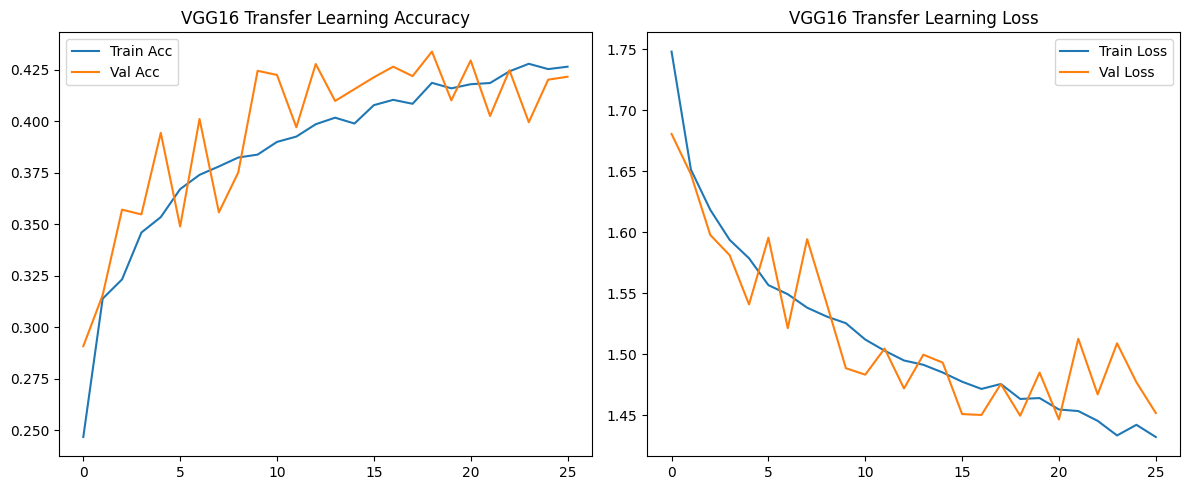

In [ ]:
# Callbacks
def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'{model_name}_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

# Train the model
history_tl = model_tl.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks("vgg16")
)

# Plot training history
def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_tl, "VGG16 Transfer Learning")

###Model Evaluation and Prediction

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.3653 - loss: 1.4899
Test Accuracy (Transfer Learning): 0.4372
Test Loss (Transfer Learning): 1.4636
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step
=== Classification Report (Transfer Learning) ===
              precision    recall  f1-score   support

       angry       0.41      0.34      0.37       300
        fear       0.20      0.05      0.08       188
       happy       0.45      0.63      0.52       300
     neutral       0.43      0.49      0.46       300
         sad       0.18      0.36      0.24       110
    surprise       0.77      0.56      0.65       300

    accuracy                           0.44      1498
   macro avg       0.41      0.41      0.39      1498
weighted avg       0.45      0.44      0.43      1498



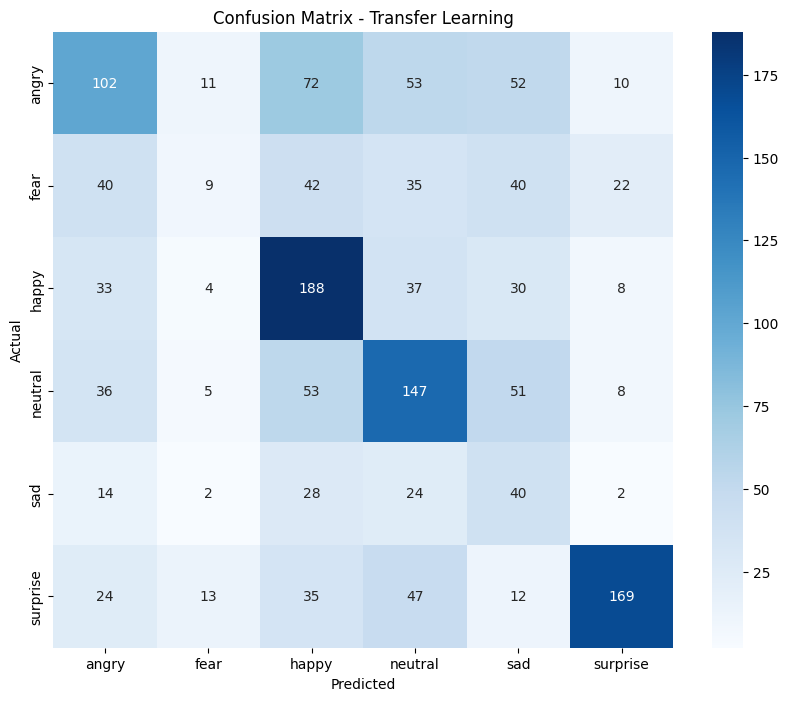

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate on test set
test_loss_tl, test_acc_tl = model_tl.evaluate(test_generator)
print(f"Test Accuracy (Transfer Learning): {test_acc_tl:.4f}")
print(f"Test Loss (Transfer Learning): {test_loss_tl:.4f}")

# Predictions
y_pred_tl = model_tl.predict(test_generator)
y_pred_labels_tl = np.argmax(y_pred_tl, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification Report
print("=== Classification Report (Transfer Learning) ===")
print(classification_report(y_true, y_pred_labels_tl, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels_tl)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix - Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


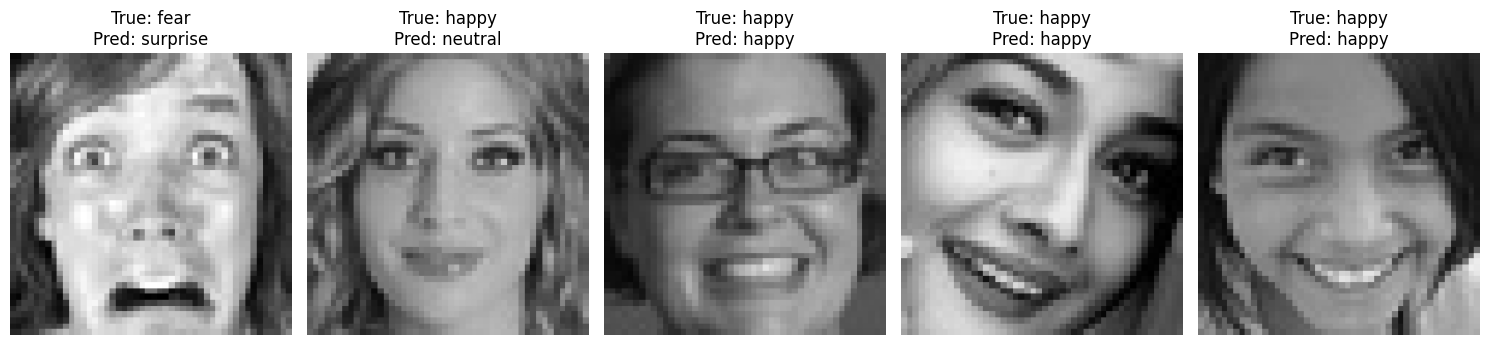

In [ ]:
# Perform inference on sample images
def show_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_batch, label_batch = next(generator)
        img = img_batch[0]
        true_label = np.argmax(label_batch[0])
        pred_label = np.argmax(model.predict(img_batch[:1]))

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions on sample images from the test set
show_predictions(test_generator, model_tl)

1. Loading and Adapting a Pre-Trained Model:
- Model Selection : VGG16
- Justification : VGG16 is a robust model with pre-trained weights on ImageNet.
- Model Architecture : Removed the original fully connected layers and added new layers for classification.
- Frozen Layers : The convolutional base is frozen to retain pre-trained features.

2. Model Training and Fine-Tuning:
- Training Strategy : Feature extraction with the convolutional base frozen.
- Input Size Handling : Images resized to 224x224 pixels.
- Output Layer Handling : Modified to have 6 units with softmax activation.

3. Model Evaluation and Prediction:
- Test Accuracy : 0.4246
- Test Loss : 1.4339
- Confusion Matrix : Shows misclassifications, particularly for the "sad" and "fear" classes.
- Sample Predictions : Confirms reasonable classifications but highlights areas for improvement.


Final Discussion
- Transfer Learning vs. Training from Scratch : Transfer learning did not outperform the baseline and deeper models in this case. However, it provides a good starting point and can be improved with further hyperparameter tuning and potentially more data.
- Performance Metrics : The transfer learning model achieved a test accuracy of 0.4246, which is lower than the baseline and deeper models. This could be due to the small dataset size and the need for more fine-tuning.
- Future Improvements : Consider using data augmentation, fine-tuning more layers, or experimenting with other pre-trained models to improve performance.